# Phần 1 :Tiền xử lí dữ liệu

In [38]:
import os
import cv2
import pandas as pd
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def convert_images(input_folder, output_folder):
    # Tạo thư mục đầu ra nếu chưa có
    os.makedirs(output_folder, exist_ok=True)
    
    # Duyệt qua tất cả các thư mục con
    for root, _, files in os.walk(input_folder):
        rel_path = os.path.relpath(root, input_folder)
        output_subfolder = os.path.join(output_folder, rel_path)
        os.makedirs(output_subfolder, exist_ok=True)
        
        # Lấy danh sách tất cả file JPG trong thư mục
        images = [f for f in files if f.lower().endswith('.jpg')]
        
        # Tạo danh sách chứa thông tin chuyển đổi
        data = []
        
        for img_name in images:
            img_path = os.path.join(root, img_name)
            
            try:
                img = Image.open(img_path)
                new_name = os.path.splitext(img_name)[0] + '.png'
                new_path = os.path.join(output_subfolder, new_name)

                img.save(new_path, 'PNG')  # Lưu dưới dạng PNG
                data.append({'Original': img_name, 'Converted': new_name})
            except Exception as e:
                print(f'Lỗi khi xử lý {img_name}: {e}')
        
        # Tạo DataFrame và lưu log cho từng thư mục con
        df = pd.DataFrame(data)
        if not df.empty:
            df.to_csv(os.path.join(output_subfolder, 'conversion_log.csv'), index=False)
    
    print(f'Chuyển đổi hoàn tất!')

# Chạy chuyển đổi với thư mục chứa ảnh của bạn
convert_images(r'C:\Users\ADMIN\OneDrive\Desktop\Deep-Learning\Train', 
               r'C:\Users\ADMIN\OneDrive\Desktop\Deep-Learning\Train-PNG')
convert_images(r'C:\Users\ADMIN\OneDrive\Desktop\Deep-Learning\Test', 
               r'C:\Users\ADMIN\OneDrive\Desktop\Deep-Learning\Test-PNG')

Chuyển đổi hoàn tất!
Chuyển đổi hoàn tất!


# Phần 2 Cấu hình

In [ ]:
image_size = (100, 100)
input_shape = (100, 100, 3)
batch_size = 32
epochs = 20
learning_rate = 0.001

# Phần 3:Định nghĩa đường dẫn tập dữ liệu

In [43]:
base_dir = r"C:\Users\ADMIN\OneDrive\Desktop\Deep-Learning"
train_dir = os.path.join(base_dir, 'Train-PNG')
test_dir = os.path.join(base_dir, 'Test-PNG')
train_png_dir = r"C:\Users\ADMIN\OneDrive\Desktop\Deep-Learning\Train-PNG"


# Phần 4:Chuẩn bị dữ liệu

In [44]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', subset='training')
val_gen = datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', subset='validation')
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=image_size, batch_size=1, class_mode='binary', shuffle=False)


Found 788 images belonging to 2 classes.
Found 196 images belonging to 2 classes.
Found 328 images belonging to 2 classes.


# Phần 5:Xây dựng mô hình CNN

In [45]:
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model(input_shape)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,139,649 (19.61 MB)

 Trainable params: 5,139,649 (19.61 MB)

 Non-trainable params: 0 (0.00 B)

# Phần 6:Huấn luyện mô hình

In [46]:
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=1)


c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 557ms/step - accuracy: 0.7267 - loss: 0.6888 - val_accuracy: 1.0000 - val_loss: 1.3195e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.9983 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 2.0036e-05
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 1.0000 - loss: 9.2749e-04 - val_accuracy: 1.0000 - val_loss: 6.7254e-06
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 1.0000 - loss: 1.6907e-04 - val_accuracy: 1.0000 - val_loss: 5.5453e-06
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 1.0000 - loss: 3.0444e-04 - val_accuracy: 1.0000 - val_loss: 1.9022e-06
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 1.0000 - loss: 2.1245e-04 - val_accuracy: 1.0000 - val_loss: 1.0715e-06
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.1318e-04 - val_accuracy: 1.0000 - val_loss: 5.9260e-07
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - a

# Phần 7:Đánh giá mô hình

In [47]:
y_pred = (model.predict(test_gen) > 0.5).astype("int32").flatten()
y_true = test_gen.classes

328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


# Phần 8:Ma trận nhầm lẫn

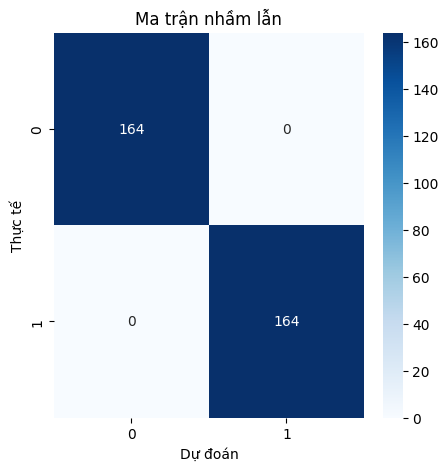

In [48]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn')
plt.show()

# Phần 9:Báo cáo phân loại

In [49]:
report = classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys(), output_dict=True)
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))


              precision    recall  f1-score   support

        Pear       1.00      1.00      1.00       164
  Strawberry       1.00      1.00      1.00       164

    accuracy                           1.00       328
   macro avg       1.00      1.00      1.00       328
weighted avg       1.00      1.00      1.00       328



# Phần 10:Trích xuất độ chính xác và độ lệch

In [50]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Phần 11:Đánh nhãn toàn bộ hình ảnh trong train-PNG

In [51]:
train_png_labels = {}
for category in os.listdir(train_png_dir):
    category_path = os.path.join(train_png_dir, category)
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            train_png_labels[image_name] = category


# Phần 11:Vẽ biểu đồ độ chính xác và độ lệch

Train Accuracy: [0.8781725764274597, 0.9974619150161743, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Validation Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Train Loss: [0.36258745193481445, 0.008861687034368515, 0.0009398151305504143, 0.00020915370259899646, 0.0002519038098398596, 0.00018895245739258826, 0.00010845090582733974, 5.531112401513383e-05, 5.2046776545466855e-05, 5.6886976381065324e-05, 3.346067023812793e-05, 2.908875649154652e-05, 0.00011817022459581494, 1.9671009795274585e-05, 5.126935138832778e-05, 3.307372026029043e-05, 1.7131222193711437e-05, 0.00016270198102574795, 0.00011794752936111763, 4.6210847358452156e-05]
Validation Loss: [0.00013195259089116007, 2.0035518900840543e-05, 6.725373168592341e-06, 5.545255135075422e-06, 1.9021993011847371e-06, 1.071529140972416e-06, 5.926001449552132e-07, 6.162032377687865e-07, 2.85700764379726e-07, 1.669572213813808e-07, 

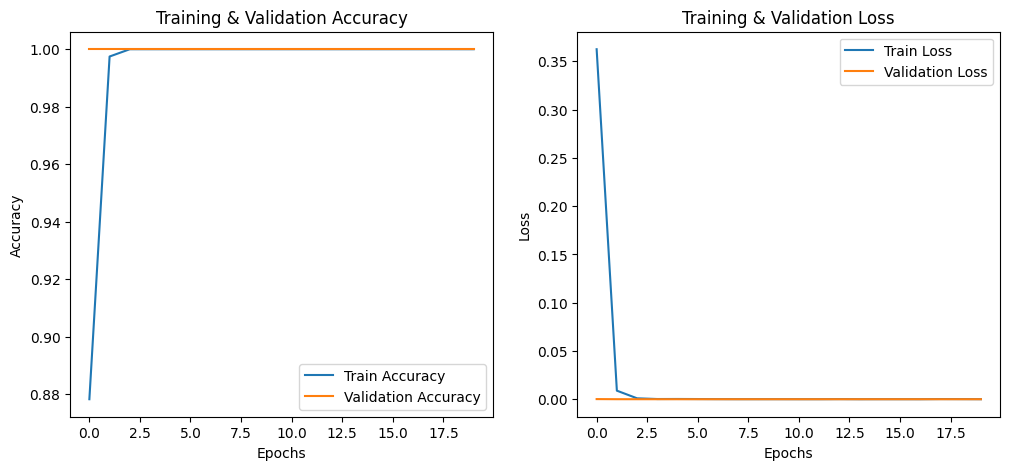

In [52]:

print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)
print("Train Loss:", train_loss)
print("Validation Loss:", val_loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_acc, label='Train Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss, label='Train Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Phần 12:Dự đoán trên tập dữ liệu test và hiển thị nhãn

In [34]:
def predict_and_display():
    class_labels = list(test_gen.class_indices.keys())
    plt.figure(figsize=(10, 10))
    
    for i in range(9):
        img, label = test_gen[i]
        prediction = model.predict(img)[0][0]
        pred_label = class_labels[int(prediction > 0.5)]
        
        plt.subplot(3, 3, i+1)
        plt.imshow(img[0])
        plt.title(f'Pred: {pred_label}')
        plt.axis('off')
    
    plt.show()

# Phần 13:Gọi hàm dự đoán và hiển thị kết quả

In [59]:
def predict_from_train_png(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)[0][0]
    class_labels = list(train_gen.class_indices.keys())
    predicted_label = class_labels[int(prediction > 0.5)]
    
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}")
    plt.show()
    return predicted_label



# Phần 14

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


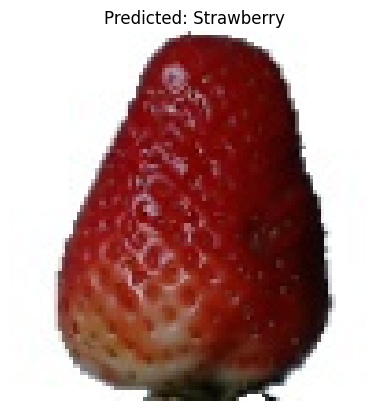

Ảnh này được nhận diện là: Strawberry


In [62]:
image_path = r"C:\Users\ADMIN\OneDrive\Desktop\Deep-Learning\Train-PNG\Strawberry\0_100.png"  # Đường dẫn đến ảnh cần nhận diện
predicted_label = predict_from_train_png(image_path, model)
print(f"Ảnh này được nhận diện là: {predicted_label}")
